## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

def calibrate_cam():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('./camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            #cv2.imshow('img',img)
            #cv2.waitKey(500)
    return objpoints, imgpoints

def undistort_img(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist
    

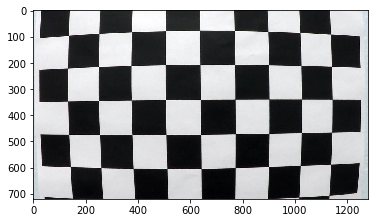

In [2]:
img = cv2.imread('./camera_cal/calibration1.jpg')
plt.imshow(img)

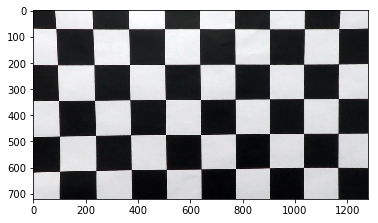

In [4]:
objpoints, imgpoints = calibrate_cam()
undistorted_img = undistort_img(img, objpoints, imgpoints)
plt.imshow(undistorted_img)

In [5]:
import os
input_images = os.listdir("test_images/")
input_images

['straight_lines1.jpg',
 'straight_lines2.jpg',
 'test1.jpg',
 'test2.jpg',
 'test3.jpg',
 'test4.jpg',
 'test5.jpg',
 'test6.jpg']

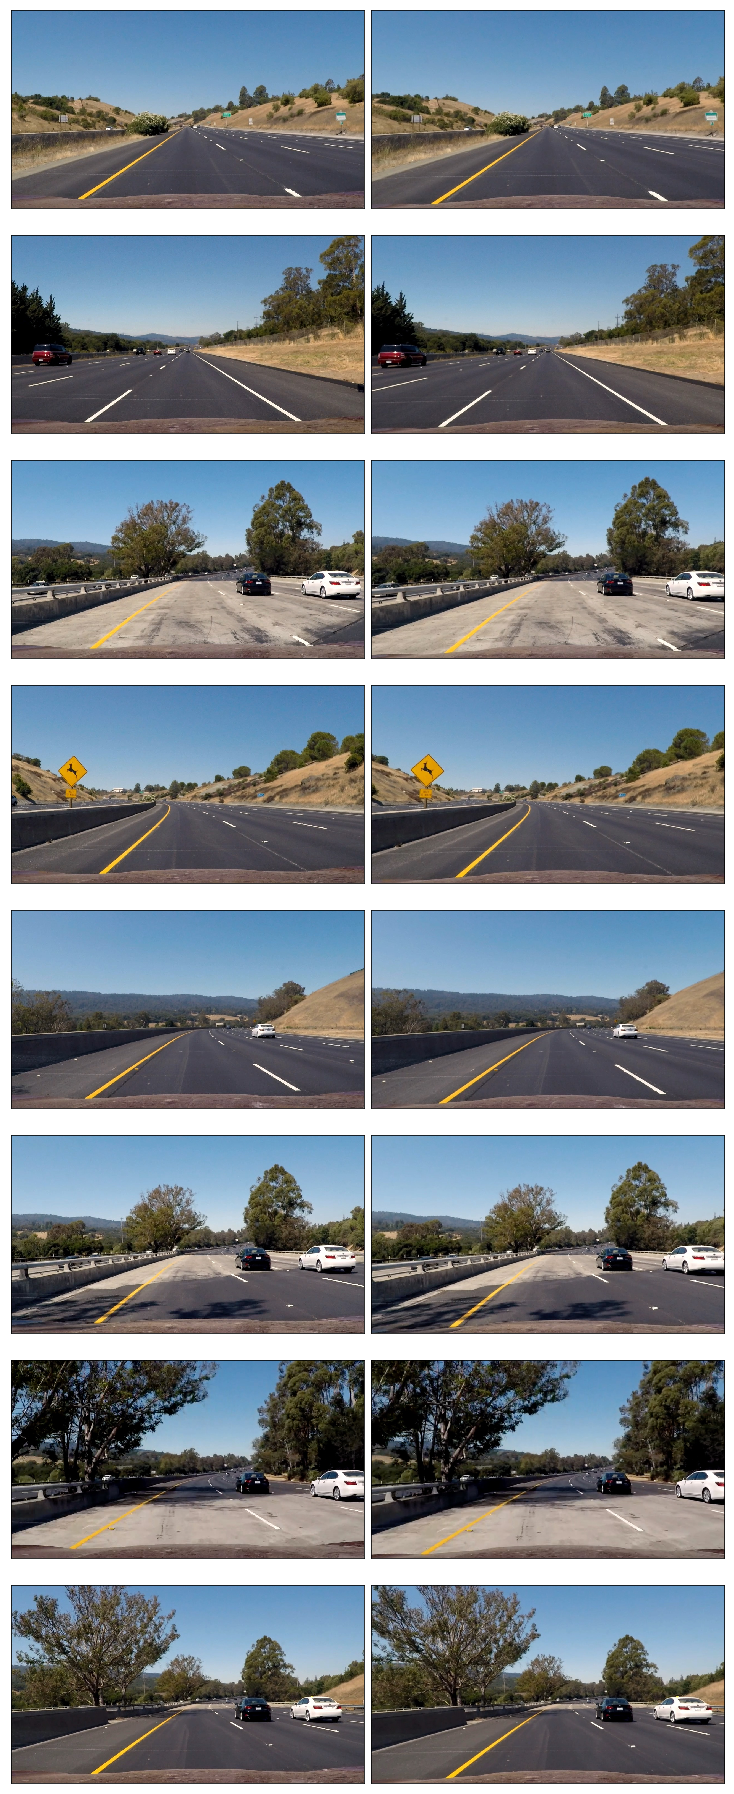

In [27]:
plt.figure(figsize=(10,25))
for i, input_image in enumerate(input_images):
    img = cv2.imread("test_images/" + input_image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(8, 2, i*2+1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(8, 2, i*2+2)
    undistorted_img = undistort_img(img, objpoints, imgpoints)
    plt.imshow(undistorted_img)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()

In [69]:

def abs_sobel_threshold(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    image = np.copy(image)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    x, y = (1, 0) if orient=='x' else (0, 1)
    sobel = cv2.Sobel(gray, cv2.CV_64F, x, y, ksize=sobel_kernel)
    sobel = np.absolute(sobel)
    sobel = np.uint8(255*sobel/np.max(sobel))
    binary_output = np.zeros_like(sobel)
    thresh_min, thresh_max = thresh
    binary_output[(sobel >= thresh_min) & (sobel <= thresh_max)] = 1
    return binary_output

def mag_threshold(image, sobel_kernel=3, mag_thresh=(0, 255)):
    image = np.copy(image)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(mag)/255 
    mag = (mag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(mag)
    thresh_min, thresh_max = mag_thresh
    binary_output[(mag >= thresh_min) & (mag <= thresh_max)] = 1
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    image = np.copy(image)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobelx = np.absolute(sobelx)
    sobely = np.absolute(sobely)
    direction = np.arctan2(sobely, sobelx)
    binary_output = np.zeros_like(direction)
    thresh_min, thresh_max = thresh
    binary_output[(direction >= thresh_min) & (direction <= thresh_max)] = 1
    return binary_output


def combined_sobel_threshold(image):
    ksize=11
    gradx = abs_sobel_threshold(image, orient='x', sobel_kernel=ksize, thresh=(50, 100))
    #grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(0, 255))
    mag_binary = mag_threshold(image, sobel_kernel=ksize, mag_thresh=(50, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))
    combined = np.zeros_like(dir_binary)
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined[(gradx == 1)  | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

def s_channel_threshold(image, thresh=(150, 255)):
    image = np.copy(image)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return s_binary  

def combine_threshold(image):
    #return np.dstack((np.zeros_like(image[:,:,0]), combined_sobel_threshold(image), s_channel_threshold(image))).astype(np.uint8)  * 255
    combined = np.zeros_like(image[:,:,0])
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined[(combined_sobel_threshold(image)==1) | (s_channel_threshold(image)==1)] = 1
    return combined

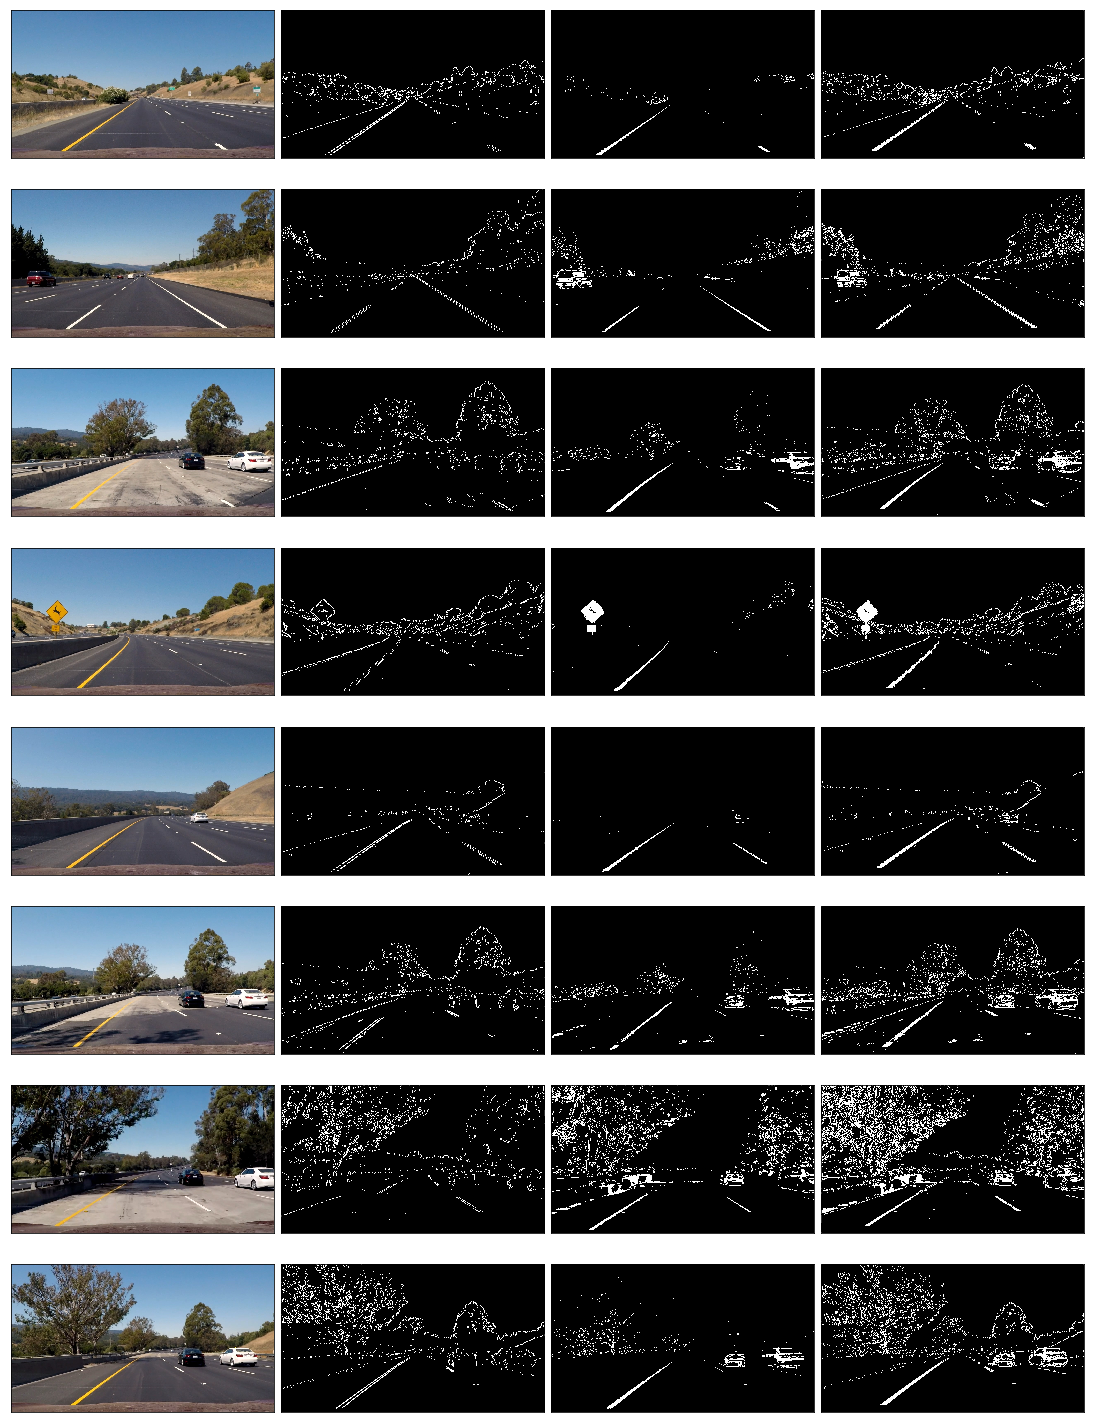

In [72]:
plt.figure(figsize=(15,20))
for i, input_image in enumerate(input_images):
    img = cv2.imread("test_images/" + input_image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(8, 4, i*4+1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(8, 4, i*4+2)
    u_img = undistort_img(img, objpoints, imgpoints)
    new_img = combined_sobel_threshold(u_img)
    plt.imshow(new_img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(8, 4, i*4+3)
    new_img = s_channel_threshold(u_img)
    plt.imshow(new_img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(8, 4, i*4+4)
    new_img = combine_threshold(img)
    plt.imshow(new_img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()